In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googlesearch import search
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import sys
import time
from time import sleep
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import ast
from scipy.stats import mannwhitneyu

# Data Retrieval

This part of the code initializes the YouTube API and fetches a list of YouTube video ids from videos that were most recently published in the YouTUbe genres 'Entertainment' and 'News &b Politics'

In [6]:
# Defining a list of YouTube API keys to iterate over later on (workaround for quota limits, cannot recommend to do that, it violates the GoogleCloud User Policy and Google is apparently not happy about that)
api_keys = ['']

api_key = ''


def get_youtube_client(api_key):
    '''
    This funciton initializes the YouTube API client.
    '''
    return build("youtube", "v3", developerKey=api_key)


In [ ]:
def fetch_video_ids(youtube, max_results=50, page_token=None, genre_id=None, published_after=None, published_before=None):
    '''
    This function fetches the Video IDs of YouTube Videos. 
    The input parameters are provided by the function: 'fetch_multiple_video_ids'.
    It also provides a token for the next page of results, to avoid retrieveing duplicates.
    '''
    try:
        request = youtube.search().list(
            part="id,snippet",
            maxResults=max_results,
            order="date",
            q="",
            type="video",
            videoCategoryId=genre_id,
            pageToken=page_token,
            publishedAfter=published_after,
            publishedBefore=published_before
        )
        response = request.execute()
        video_ids = [item['id']['videoId'] for item in response['items']]
        return video_ids, response.get("nextPageToken", None)
    
    # Handling possible errors (e.g.: "error 403" indicates exceeding the daily qouta limit)
    except HttpError as e:
        print(f"An HTTP error {e.resp.status} occurred: {e.content}")
        return [], None


In [ ]:
def fetch_multiple_video_ids(api_keys, total_max_results=1600, genre_id=None):
    '''
    This function fetches multiple Video IDs, up to the pre-defined amount.
    The idea is to loop over a pre-defined list of api-keys in order to trick the daily YouTube API quota limit of 50 video id retrievals per project per day.
    
    The function is also able to have a pre-defined time range from which it retrieves Video IDs. 
    All fetched videos were published around 3 hours earlier than that time range. This built in method of the YouTube API only works with a slight delay.
    
    This function calls the previously defined function 'fetch_video_ids'.
    '''
    
    all_video_ids = []
    next_page_token = None
    remaining_results = total_max_results
    max_results_per_key = 50

    # Set the time filters for videos published between 4 and 0 hours ago.
    now = datetime.utcnow()
    published_before = now - timedelta(hours=0)
    published_after = now - timedelta(hours=4)
    
    # Iterating over the pre-defined list of api-keys to 'trick' YouTube's quota limit. The code uses the next keys after 'max_results_per_key' retrievals.
    for api_key in api_keys:
        youtube = get_youtube_client(api_key)
        quota_for_key = min(max_results_per_key, remaining_results)

        while quota_for_key > 0:
            video_ids, next_page_token = fetch_video_ids(
                youtube, min(50, quota_for_key), next_page_token, genre_id, 
                
                # Only retrieving from previously defined time span
                published_after=published_after.isoformat("T") + "Z", 
                published_before=published_before.isoformat("T") + "Z"
            )
            if not video_ids:
                break

            # Only add unique video IDs
            unique_video_ids = [vid for vid in video_ids if vid not in all_video_ids]
            all_video_ids.extend(unique_video_ids)

            remaining_results -= len(unique_video_ids)
            quota_for_key -= len(unique_video_ids)
            
            # Defining an exit condition for the function
            if next_page_token is None or remaining_results <= 0:
                break

            sleep(1)
            
    return all_video_ids[:total_max_results]

In [19]:
def fetch_genre_videos_to_dataframe(label_name, genre_id, api_keys, total_max_results=1600):
    '''
    This function adds a column to the corresponding dataframe containing the label under which name the video was published.
    The function also calls the previously defined function 'fetch_multiple_video_ids'.
    '''
    video_ids = fetch_multiple_video_ids(api_keys, total_max_results, genre_id)
    df_name = f"{label_name}_df"
    globals()[df_name] = pd.DataFrame({
        'video_ids': video_ids,
        'label_name': [label_name] * len(video_ids)
    })
    print(f"Total number of video_ids retrieved: {len(video_ids)}")
    return globals()[df_name]


In [20]:
# Calling the previously defined functions for the genres, deleting duplicates and resetting the index
# YouTube's genre id for 'entertainment' is 24, for 'news' it is 25
entertainment_df = fetch_genre_videos_to_dataframe(label_name = 'entertainment', genre_id = '24', api_keys)
entertainment_df = entertainment_df.drop_duplicates(subset=['video_ids']).reset_index(drop=True)

news_df = fetch_genre_videos_to_dataframe(label_name = 'news & politics', genre_id = '25', api_keys)
news_df = news_df.drop_duplicates(subset=['video_ids']).reset_index(drop=True)

### Fetching other infos based on video ids

In [166]:
def fetch_video_details(video_id, api_key):
    '''
    This function is designed to extract all relevant video parameters from the response of the YouTube API. 
    It is called by the following function 'fetch_and_update_video_details'.
    '''
    params = {
        'part': 'statistics,snippet,contentDetails',
        'id': video_id,
        'key': api_key
    }
    response = requests.get('https://www.googleapis.com/youtube/v3/videos', params=params).json()
    try:
        if 'items' in response and len(response['items']) > 0:
            item = response['items'][0]
            view_count = int(item['statistics'].get('viewCount', 0)) 
            published_at = item['snippet']['publishedAt']
            channel_id = item['snippet']['channelId']
            

            return view_count, published_at, channel_id
        else:
            return 0, None, 0, 0, None, 0
    except KeyError as e:
        print(f"KeyError occurred for video_id {video_id}: {e}")
        return 0, None, 0, 0, None, 0



In [202]:
def fetch_and_update_video_details(df, video_id_column, api_key, suffix):
    '''
    This function adds columns with information about the videos and the YouTube channel on which it was published.
    Becaus some parameters like the view count and the retrieval time are retrieved at different points in time, they are added based on a specific suffix. 
    
    The suffixes respond to:
    
    Suffix 0: time when the video ids were firstly retrieved.
    Suffix 1: 3 hours after the first retreival.
    Suffix 2: 6 hours after the first retreival.
    Suffix 3: 24 hours after the first retrieval.
    Suffix 4: 72 hours after the first retrieval.
    Suffix 5: 7 days after the first retrieval.
    '''
    # Initialize empty lists to store data
    view_counts = []
    published_dates = []
    retrieval_times = []
    channel_ids = []

    # Loop through video IDs and adding a progres bar
    for video_id in tqdm(df[video_id_column], desc='Fetching video details', unit='video'):
        view_count, published_at, channel_id = fetch_video_details(video_id, api_key)
        
        # Append fetched details to corresponding lists
        view_counts.append(view_count)

        retrieval_times.append(datetime.now())
        
        # Only fetching the channel_id and the publication time when the suffix is 0
        if suffix == 0:
            published_dates.append(published_at)
            channel_ids.append(channel_id)

    # Update DataFrame columns with fetched details
    df[f'View_Count_{suffix}'] = view_counts
    df[f'Retrieval_Time_{suffix}'] = retrieval_times

    # Only adding the following parameters if the suffix is 0
    if suffix == 0:
        df['Published_At'] = published_dates
        df['Channel_ID'] = channel_ids
    
    return df


In [168]:
# Applying the previously defined function fetch_and_update_video_details
entertainment_df = fetch_and_update_video_details(entertainment_df, 'video_ids', api_key, suffix=5)
news_df = fetch_and_update_video_details(news_df, 'video_ids', api_key, suffix=5)

Fetching video details: 100%|██████████| 631/631 [00:47<00:00, 13.39video/s]


In [171]:
# Saving the data in a csv-file
#news_df.to_csv('news_df.csv')
#entertainment_df.to_csv('entertainment_df.csv')

In [131]:
entertainment_df = pd.read_csv('entertainment_df.csv')
news_df = pd.read_csv('news_df.csv')

# Further Preprocessing


In [132]:
# The following functions add the number of subscribers and the country code of the channel to the dataframe
def fetch_channel_subscribers_countrycode(channel_ids, api_key):
    '''
    This function retrieves the subscriber count and country of YouTube channels
    based on the YouTube channel id. The function is called by 'add_channel_subscribers_countrycode'.
    '''
    params = {
        'part': 'statistics,snippet',
        'id': ','.join([str(x) for x in channel_ids]),
        'key': api_key
    }
    response = requests.get('https://www.googleapis.com/youtube/v3/channels', params=params).json()
    
    subscriber_counts = {}
    country_codes = {}
    
    if 'items' in response:
        for item in response['items']:
            channel_id = item['id']
            subscriber_count = int(item['statistics']['subscriberCount'])
            country = item['snippet'].get('country', 'Not specified')
            
            subscriber_counts[channel_id] = subscriber_count
            country_codes[channel_id] = country
    else:
        print("API response does not contain valid data.")
        
    return subscriber_counts, country_codes

In [133]:
def add_channel_subscribers(df, channel_id_column, api_key, batch_size=50):
    '''
    This function adds the YouTube channel id, subscriber count, and country code
    to the corresponding row of the defined dataframe.
    '''
    unique_channel_ids = df[channel_id_column].unique()
    total_channels = len(unique_channel_ids)
    
    subscriber_counts = {}
    country_codes = {}
    
    for i in tqdm(range(0, total_channels, batch_size), desc="Fetching Subscriber Counts and Countries"):
        batch_channel_ids = unique_channel_ids[i:i + batch_size]
        batch_subscriber_counts, batch_country_codes = fetch_channel_subscribers_countrycode(batch_channel_ids, api_key)
        
        subscriber_counts.update(batch_subscriber_counts)
        country_codes.update(batch_country_codes)

    df['Subscriber_Count'] = df[channel_id_column].map(subscriber_counts).fillna(0).astype(int)
    df['Country_Code'] = df[channel_id_column].map(country_codes).fillna('Not specified')
    
    return df


In [134]:
# Applying the previous functions to the two dataframes to add the number of subscribers and the countrycode
entertainment_df = add_channel_subscribers(entertainment_df, 'Channel_ID', api_key)
news_df = add_channel_subscribers(news_df, 'Channel_ID', api_key)

Fetching Subscriber Counts and Countries: 100%|██████████| 8/8 [00:01<00:00,  7.11it/s]


In [135]:
# This code saves the continent code for country codes in a seperate variable
def country_to_continent(country_code):
    try:
        continent_code = country_alpha2_to_continent_code(country_code)
        return continent_code
    except KeyError:
        return 'Unknown'


entertainment_df['Continent'] = entertainment_df['Country_Code'].apply(country_to_continent)
news_df['Continent'] = news_df['Country_Code'].apply(country_to_continent)

In [136]:
# Creating a function that removes all rows, where the 'View_Count' is 0 => indicator for deleted video or that something went wrong when retrieving the data
def filter_and_reset(df):

    filtered_df = df[
        (df['View_Count_1'] != 0) &
        (df['View_Count_2'] != 0) &
        (df['View_Count_3'] != 0) &
        (df['View_Count_4'] != 0) & 
        (df['View_Count_5'] != 0) & 
        (df['Subscriber_Count'] !=0)]
    
    # Reset the index
    filtered_df.reset_index(drop=True, inplace=True)
    
    return filtered_df

In [137]:
# Applying the pre-defined function to the dfs
entertainment_df = filter_and_reset(entertainment_df)
news_df = filter_and_reset(news_df)

In [138]:
def convert_datetime_to_timestamp(df, n):
    '''
    This function converts the datetime format of the retrieved dates to a timestamp format.
    '''
    
    time_columns = [f'Retrieval_Time_{i}' for i in range(n)] + ['Published_At']
    
    for col in time_columns:
        df[col] = pd.to_datetime(df[col]).astype(int) // 10**9
    return df


In [139]:
# Applying the previously defined function 'convert_datetine_to_timestamp' to the two dfs
entertainment_df = convert_datetime_to_timestamp(entertainment_df, 6)
news_df = convert_datetime_to_timestamp(news_df, 6)

In [140]:
# Excluding outliers from the datasets
entertainment_df = entertainment_df[entertainment_df['View_Count_5'] <= entertainment_df['View_Count_5'].quantile(0.95)]
news_df = news_df[news_df['View_Count_5'] <= news_df['View_Count_5'].quantile(0.95)]


In [141]:
# In this part the two dataframes 'entertainment_df' and 'news_df' are merged 
def generate_column_names(prefix, max_index):
    return [f"{prefix}_{i}" for i in range(max_index + 1)]

# Generate the list of columns to use
columns_to_use = ['video_ids', 'label_name', 'Published_At', 'Channel_ID', 'Subscriber_Count', 'Continent']
columns_to_add = ['Retrieval_Time', 'View_Count']

for col in columns_to_add:
    columns_to_use.extend(generate_column_names(col, 5))


entertainment_df_filtered = entertainment_df[columns_to_use]
news_df_filtered = news_df[columns_to_use]

# Concatenating the two dataframes and resetting the index
merged_df = pd.concat([entertainment_df_filtered, news_df_filtered], ignore_index=True)
merged_df = merged_df.sample(frac=1).reset_index(drop=True)


# Model

In this part the actual model is trained. I use a Random Forest Regression model and train it with time series data.

In [142]:
def train_and_evaluate_model(df, retrieval_times, view_counts, target_col):
    '''
    This function uses Random Forest Regression to create a predictive model that is supposed to predict the amount of clicks of YouTube videos at a given point in time after their publication.
    The function also calculates the error (in percent) by which the prediction differs from the actual click numbers.
    For prediction purposes, the original dataset is split into a training set (80%) and a test set (20%).
    Random Forest Regression uses bootstrapping in order to make implications on the actual distribution.
    '''
    
    retrieval_cols = [f"Retrieval_Time_{i}" for i in retrieval_times]
    view_cols = [f"View_Count_{i}" for i in view_counts]
    feature_cols = ['Subscriber_Count'] + retrieval_cols + view_cols

    # Defining feature columns and target column
    X = df[feature_cols]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

    model = RandomForestRegressor(n_estimators=100, random_state=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    error_percent = round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100, 2)
    
    return error_percent


In [143]:
# In this part I will iterate several times and repeatadly apply the previously defined function 'train_and_evaluate_model' to the dataframes news_df, entertainment_df and merged_df
# The idea is to make sure not to introduce a bias to the model by making sure the length of the dataframes are always the same
# This will be guaranteed by taking a fix number of random row samples from every dataframe and applying the model on these subsamples

error_matrix = []

max_retrieval_time = 5  
max_view_count = 5    
target_col = 'View_Count_5'

num_iterations = 100

for i in range(max_retrieval_time):
    for j in range(max_view_count):
        if i == j:
            retrieval_times = list(range(i+1))
            view_counts = list(range(j+1))
            feature_string = f"{view_counts}"
            
            entertainment_errors = []
            news_errors = []
            merged_errors = []
            

            for k in range(num_iterations):

                            # Shuffle and sample dataset
                            min_length = min(len(entertainment_df), len(news_df))

                            entertainment_df_sample = entertainment_df.sample(n=min_length).reset_index(drop=True)
                            news_df_sample = news_df.sample(n=min_length).reset_index(drop=True)
                            merged_df_sample = merged_df.sample(n=min_length).reset_index(drop=True)

                            # Compute and store errors
                            entertainment_errors.append(train_and_evaluate_model(entertainment_df_sample, retrieval_times, view_counts, target_col))
                            news_errors.append(train_and_evaluate_model(news_df_sample, retrieval_times, view_counts, target_col))
                            merged_errors.append(train_and_evaluate_model(merged_df_sample, retrieval_times, view_counts, target_col))

            
            error_matrix.append([feature_string, entertainment_errors, news_errors, merged_errors])

df_error_distributions = pd.DataFrame(error_matrix, columns=['Retrieval_Time', 'Entertainment_Errors', 'News_Errors', 'Merged_Errors'])

In [145]:
# Applying the non-parametric Mann–Whitney U test to see whether the differences in mean errors are statistically significant or not

alpha = 0.05

for index, row in df_error_distributions.iterrows():
    retrieval_time = row['Retrieval_Time']
    entertainment_errors = row['Entertainment_Errors']
    news_errors = row['News_Errors']
    merged_errors = row['Merged_Errors']

    print(f"For Retrieval Time '{retrieval_time}':")
    print(f"\tAverage Entertainment Error: {np.mean(entertainment_errors):.2f}")
    print(f"\tAverage News Error: {np.mean(news_errors):.2f}")
    print(f"\tAverage Merged Error: {np.mean(merged_errors):.2f}")

    # Comparing Merged Errors vs Entertainment Errors
    U_statistic_ent, p_value_ent = mannwhitneyu(merged_errors, entertainment_errors)
    if p_value_ent < alpha:
        print(f"\tThe differences between the Merged and Entertainment errors are statistically significant (p-value = {p_value_ent:.5f})")
    else:
        print(f"\tThe differences between the Merged and Entertainment errors are not statistically significant (p-value = {p_value_ent:.5f})")

    # Comparing Merged Errors vs News Errors
    U_statistic_news, p_value_news = mannwhitneyu(merged_errors, news_errors)
    if p_value_news < alpha:
        print(f"\tThe differences between the Merged and News errors are statistically significant (p-value = {p_value_news:.5f})\n")
    else:
        print(f"\tThe differences between the Merged and News errors are not statistically significant (p-value = {p_value_news:.5f})\n")


For Retrieval Time '[0]':
	Average Entertainment Error: 141.64
	Average News Error: 177.38
	Average Merged Error: 176.12
	The differences between the Merged and Entertainment errors are statistically significant (p-value = 0.00009)
	The differences between the Merged and News errors are not statistically significant (p-value = 0.40819)

For Retrieval Time '[0, 1]':
	Average Entertainment Error: 62.70
	Average News Error: 53.14
	Average Merged Error: 64.52
	The differences between the Merged and Entertainment errors are not statistically significant (p-value = 0.67340)
	The differences between the Merged and News errors are statistically significant (p-value = 0.00000)

For Retrieval Time '[0, 1, 2]':
	Average Entertainment Error: 48.90
	Average News Error: 41.11
	Average Merged Error: 50.68
	The differences between the Merged and Entertainment errors are not statistically significant (p-value = 0.55596)
	The differences between the Merged and News errors are statistically significant (

In [190]:
# Calculating the mean error values for the three different dataframes 
df_error_distributions['Mean Entertainment Error'] = df_error_distributions['Entertainment_Errors'].apply(np.mean)
df_error_distributions['Mean News Error'] = df_error_distributions['News_Errors'].apply(np.mean)
df_error_distributions['Mean Merged Error'] = df_error_distributions['Merged_Errors'].apply(np.mean)

# Extract only required columns
df_means = df_error_distributions[['Retrieval_Time', 'Mean Entertainment Error', 'Mean News Error', 'Mean Merged Error']].copy()

# Setting a dictionary for time values and their descriptions
time_to_description = {
    0: "Time of retrieval",
    1: "3 hours after first retrieval",
    2: "6 hours after first retrieval",
    3: "24 hours after first retrieval",
    4: "72 hours after first retrieval"
}

df_means['Retrieval_Time'] = df_means.index.map(time_to_description)

df_means = df_means.rename(columns={"Retrieval_Time": "Including Data from:"})

In [192]:
latex_output = df_means.to_latex(index=False)
print(latex_output)

\begin{tabular}{lrrr}
\toprule
Including Data from: & Mean Entertainment Error & Mean News Error & Mean Merged Error \\
\midrule
Time of retrieval & 141.641200 & 177.384100 & 176.118400 \\
3 hours after first retrieval & 62.697800 & 53.140000 & 64.523500 \\
6 hours after first retrieval & 48.899300 & 41.112600 & 50.677900 \\
24 hours after first retrieval & 24.697000 & 19.740100 & 24.260000 \\
72 hours after first retrieval & 11.538000 & 12.335900 & 12.021200 \\
\bottomrule
\end{tabular}



# Plots

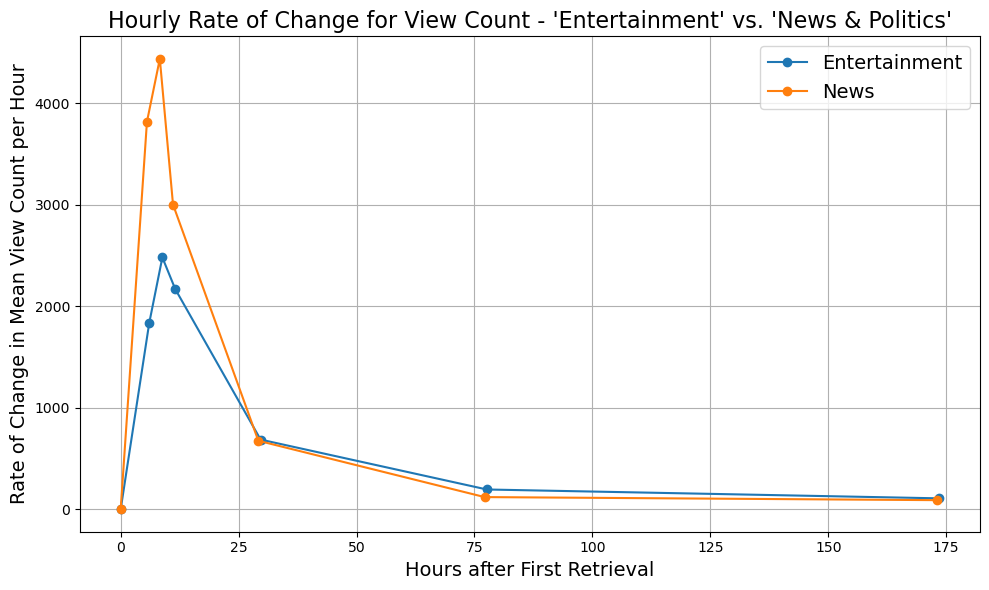

In [235]:
def plot_normalized_rate_of_change(df, label):
    '''
    This function calculates and plots the normalized rate of change of mean view count per hour 
    against the hours after the first retrieval.
    It computes the rate of change based on 6 retrieval times relative to the mean 'Published_At' time.
    '''
    mean_retrieval_times = [0]
    mean_rate_of_change_per_hour = [0]
    
    mean_published_at = df['Published_At'].mean()
    prev_mean_view_count = 0
    prev_mean_retrieval_time_hours = 0

    for i in range(6):
        mean_retrieval_time = df[f'Retrieval_Time_{i}'].mean()
        mean_view_count = df[f'View_Count_{i}'].mean()

        mean_retrieval_time_hours = (mean_retrieval_time - mean_published_at) / 3600.0
        time_diff = mean_retrieval_time_hours - prev_mean_retrieval_time_hours
        if time_diff > 0:
            rate_of_change_per_hour = (mean_view_count - prev_mean_view_count) / time_diff
        else:
            rate_of_change_per_hour = 0
        
        prev_mean_view_count = mean_view_count
        prev_mean_retrieval_time_hours = mean_retrieval_time_hours
        mean_retrieval_times.append(mean_retrieval_time_hours)
        mean_rate_of_change_per_hour.append(rate_of_change_per_hour)

    plt.plot(mean_retrieval_times, mean_rate_of_change_per_hour, marker='o', label=label)


# First plot
plt.figure(figsize=(10, 6))
plot_normalized_rate_of_change(entertainment_df, 'Entertainment')
plot_normalized_rate_of_change(news_df, 'News')
plt.xlabel('Hours after First Retrieval', fontsize = 14)
plt.ylabel('Rate of Change in Mean View Count per Hour', fontsize = 14)
plt.title("Hourly Rate of Change for View Count - 'Entertainment' vs. 'News & Politics'", fontsize = 16)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()  
plt.savefig("Normalized_Rate_of_Change.png", dpi=1000)
plt.show()

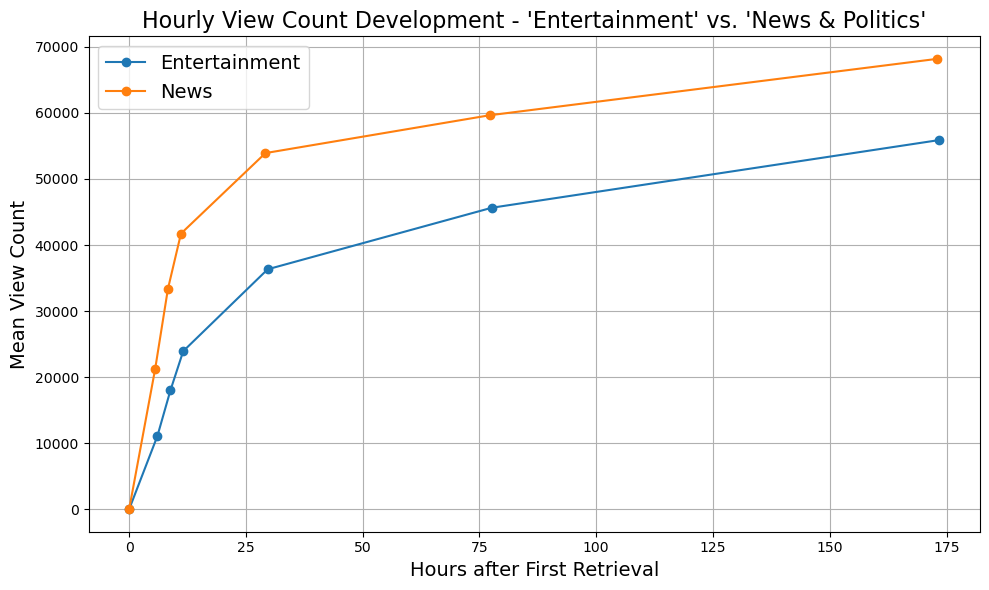

In [236]:
def plot_mean_view_counts(df, label):
    '''
    This function calculates and plots the mean view count against the hours 
    after the first retrieval.
    It computes the mean view counts based on 6 retrieval times relative to the mean 'Published_At' time.
    '''
    mean_retrieval_times = [0]
    mean_view_counts = [0]
    
    mean_published_at = df['Published_At'].mean()

    for i in range(6):
        mean_retrieval_time = df[f'Retrieval_Time_{i}'].mean()
        mean_view_count = df[f'View_Count_{i}'].mean()
        mean_retrieval_time_hours = (mean_retrieval_time - mean_published_at) / 3600.0
        
        mean_retrieval_times.append(mean_retrieval_time_hours)
        mean_view_counts.append(mean_view_count)

    plt.plot(mean_retrieval_times, mean_view_counts, marker='o', label=label)


plt.figure(figsize=(10, 6))
plot_mean_view_counts(entertainment_df, 'Entertainment')
plot_mean_view_counts(news_df, 'News')
plt.xlabel('Hours after First Retrieval', fontsize = 14)
plt.ylabel('Mean View Count', fontsize = 14)
plt.title("Hourly View Count Development - 'Entertainment' vs. 'News & Politics'", fontsize = 16)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()  
plt.savefig("Mean_View_Count_Development.png", dpi=1000)
plt.show()


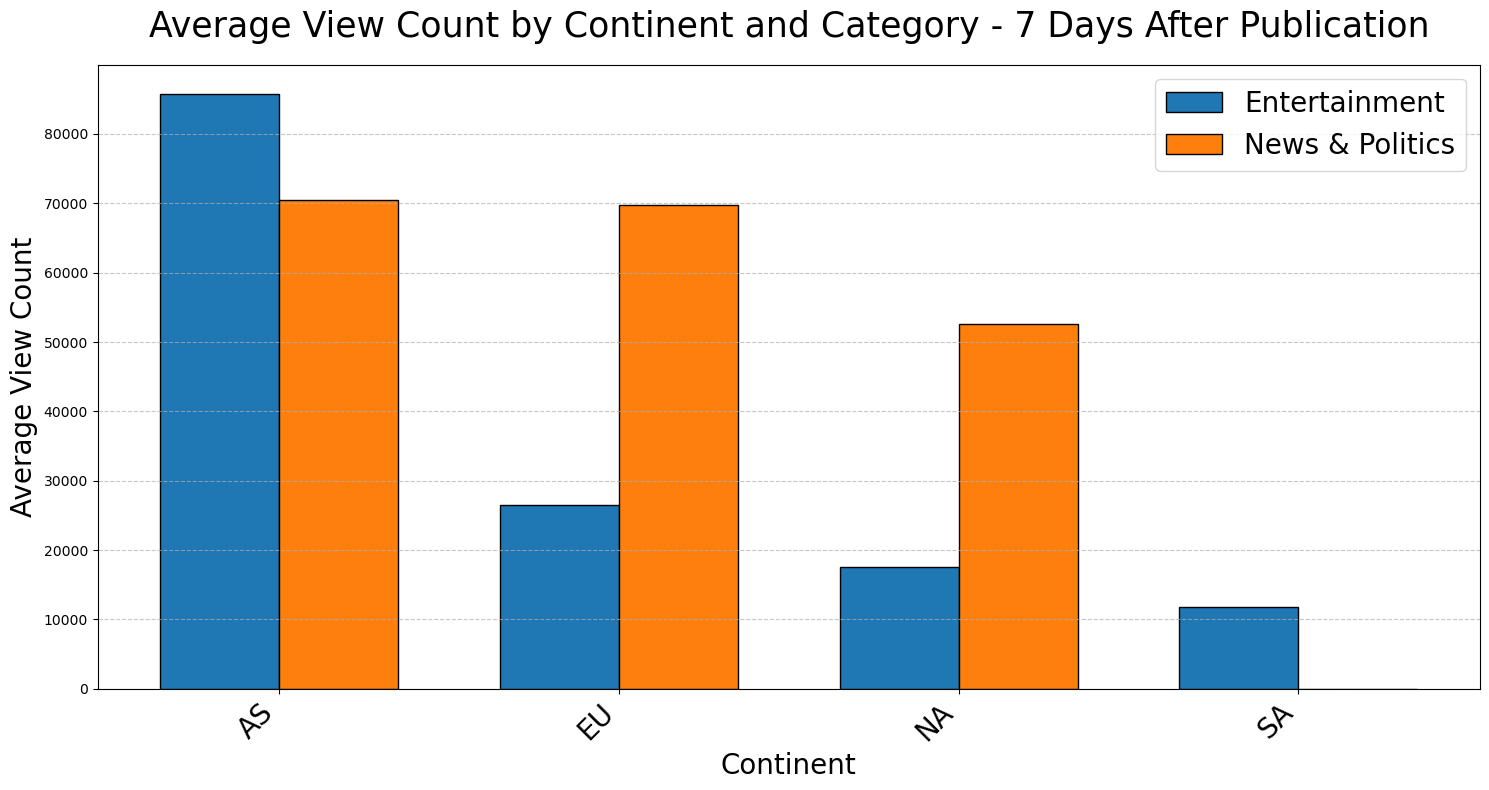

In [223]:
# Plotting the average view count for the video categories 'Entertainment' and 'News & Politics' 7 days after their publication
def filter_df(df):
    '''
    This function excludes all continents that account for less than 3 percent of the videos in the dataset.
    '''
    total = len(df)
    continent_counts = df['Continent'].value_counts()
    include_continents = continent_counts[continent_counts/total >= 0.03].index
    include_continents = [continent for continent in include_continents if continent != 'Unknown']
    return df[df['Continent'].isin(include_continents)]

entertainment_filtered_df = filter_df(entertainment_df)
news_filtered_df = filter_df(news_df)

# Calculate average view counts
avg_views_by_continent_entertainment = entertainment_filtered_df.groupby('Continent')['View_Count_5'].mean().sort_values(ascending=False)
avg_views_by_continent_news = news_filtered_df.groupby('Continent')['View_Count_5'].mean().sort_values(ascending=False)

# Reindexing
all_indices = avg_views_by_continent_entertainment.index.union(avg_views_by_continent_news.index)
avg_views_by_continent_entertainment = avg_views_by_continent_entertainment.reindex(all_indices, fill_value=0)
avg_views_by_continent_news = avg_views_by_continent_news.reindex(all_indices, fill_value=0)

# Setting the colors for the plot
tab10_colors = plt.cm.tab10.colors
blue_rgb = tab10_colors[0]
orange_rgb = tab10_colors[1]

fig, ax = plt.subplots(figsize=(15, 8))

# Main Title for the Entire Figure
ax.set_title('Average View Count by Continent and Category - 7 Days After Publication', fontsize=25, pad=20)

# Plotting the data
bar_width = 0.35
ind = np.arange(len(avg_views_by_continent_entertainment))
p1 = ax.bar(ind - bar_width/2, avg_views_by_continent_entertainment, bar_width, color=blue_rgb, edgecolor='black', label='Entertainment')
p2 = ax.bar(ind + bar_width/2, avg_views_by_continent_news, bar_width, color=orange_rgb, edgecolor='black', label='News & Politics')

ax.set_ylabel('Average View Count', fontsize=20)
ax.set_xlabel('Continent', fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(avg_views_by_continent_entertainment.index, rotation=45, ha='right', fontsize=20)
ax.legend(fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("Mean_View_Count_Continent_Category.png", dpi=1000)
plt.show()



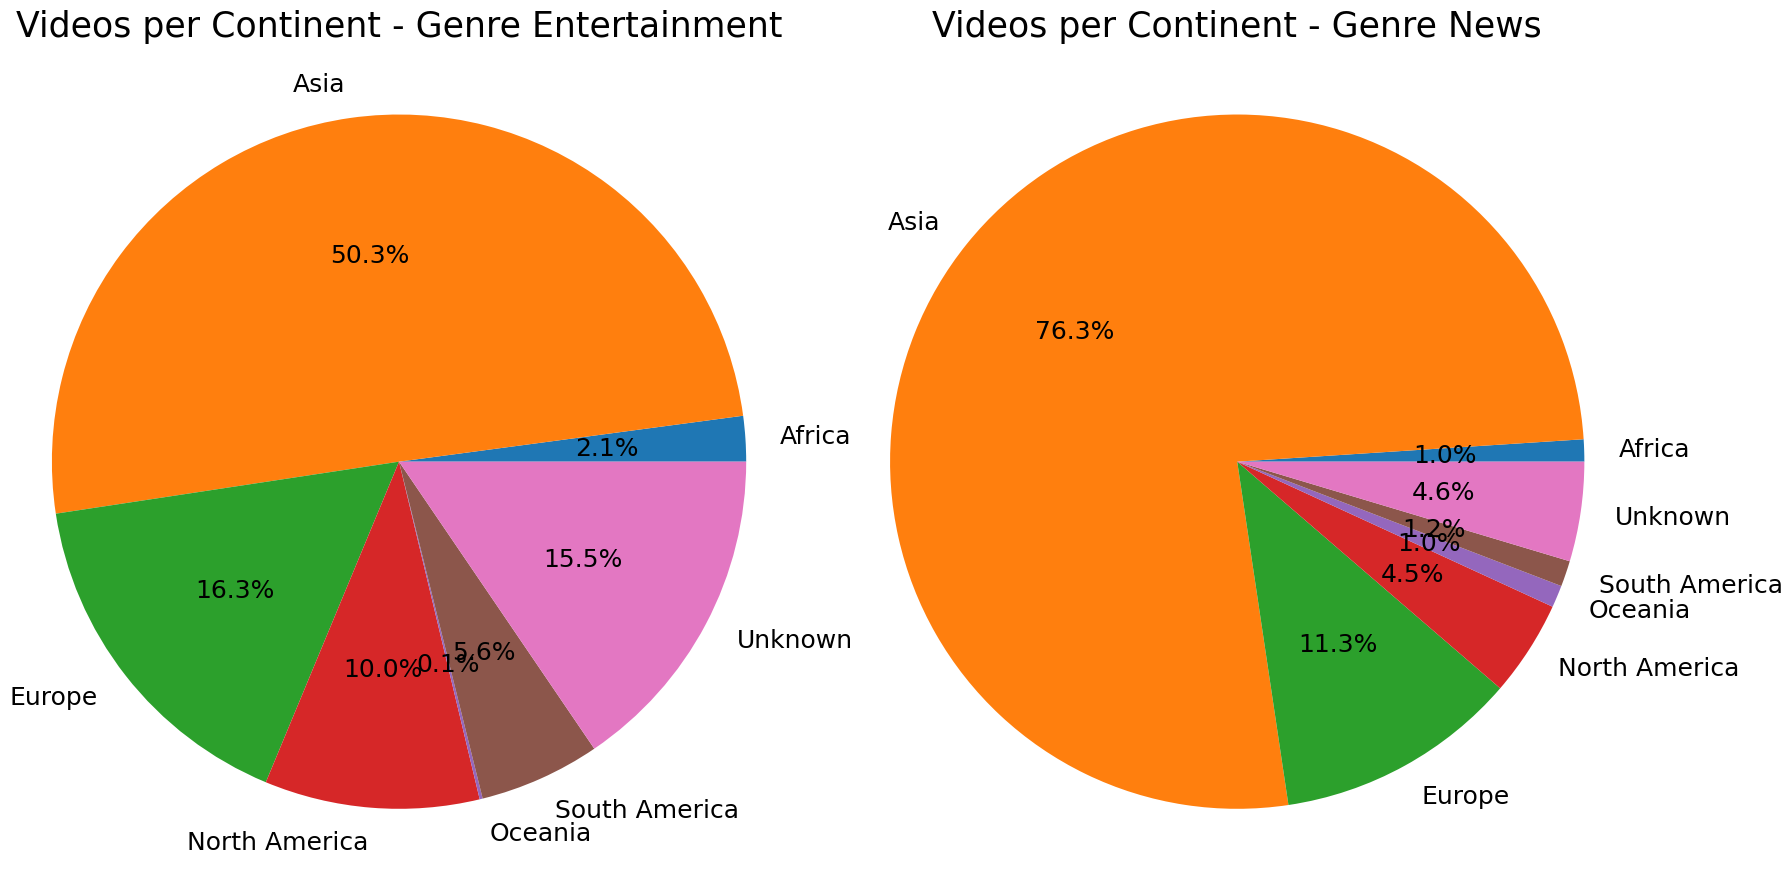

In [239]:
def plot_continent_distribution(ax, df, title, colors):
    # Map short continent codes to full names
    continent_map = {'AS': 'Asia', 'EU': 'Europe', 'SA': 'South America', 
                     'NA': 'North America', 'AF': 'Africa', 'Unknown': 'Unknown', 'OC': 'Oceania'}
    
    continent_count = df['Continent'].value_counts().sort_index()
    new_fontsize = 18

    labels = [f"{continent_map[continent]}" for continent, perc in (continent_count / len(df)).items()]
    colors = [colors[i] for i, continent in enumerate(continent_count.index)]
    
    ax.pie(continent_count, labels=labels, autopct=lambda p: f'{p:.1f}%', colors=colors, textprops={'fontsize': new_fontsize})
    ax.set_title(title, fontsize=25)
    ax.axis("equal")  
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

tab10_colors = plt.cm.tab10.colors

plot_continent_distribution(axes[0], entertainment_df, 'Videos per Continent - Genre Entertainment', tab10_colors)
plot_continent_distribution(axes[1], news_df, 'Videos per Continent - Genre News', tab10_colors)


for ax in axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

fig.tight_layout()  
plt.savefig("Portion_Continent_Videos.png", dpi=1000)
plt.show()

